#Cats e dogs


In [ ]:
#importação das bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.layers import RandomFlip, RandomRotation, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
data_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
#para fazer o download do arquivo ZIP do conjunto de dados, salvando localmente
data_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=data_url, extract=True)
#o conjunto de dados extraído
base_dir = os.path.join(os.path.dirname(data_path), 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Defição
image_size = (160, 160)
# o tamanho das imagens que serão utilizadas durante o treinamento.



68606236/68606236 [==============================] - 1s 0us/step


Conjunto de dados de treino

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, # para criar um conjunto de dados de imagens a partir do diretório de treinamento
                                                            shuffle=True, #indica que as imagens serão embaralhadas aleatoriamente durante o carregamento.
                                                            batch_size=32, #tamnho do lote
                                                            image_size=image_size)

Found 2000 files belonging to 2 classes.


Conjunto de dados de validação

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,#indica que as imagens serão embaralhadas aleatoriamente durante o carregamento.
                                                                 batch_size=32,
                                                                 image_size=image_size)

Found 1000 files belonging to 2 classes.


Visualizar algumas imagens do dataset

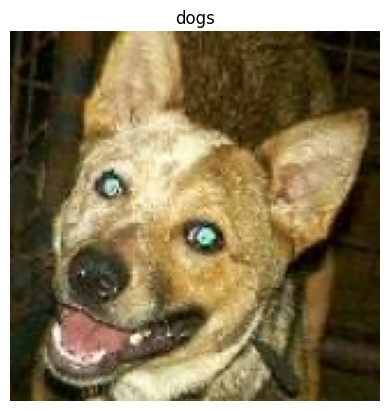

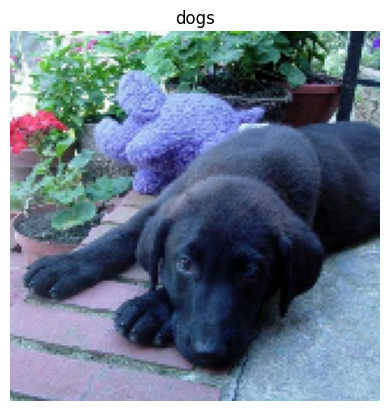

In [ ]:
class_names = train_dataset.class_names

# Carrega um lote de imagens e rótulos
images, labels = next(iter(train_dataset))

# Exibe a imagem de índice 5
plt.imshow(images[5].numpy().astype("uint8"))
plt.title(class_names[labels[5]])
plt.axis("off")
plt.show()

# Exibe a imagem de índice 20
plt.imshow(images[20].numpy().astype("uint8"))
plt.title(class_names[labels[20]])
plt.axis("off")
plt.show()


In [ ]:
num_elements = tf.data.experimental.cardinality(validation_dataset)
# é usado para obter o número de lotes (batches) no conjunto de dados de validação. Isso retorna um objeto representando o número de elementos no conjunto de dados.

test_dataset = validation_dataset.take(num_elements // 5)
#cria um novo conjunto de dados de teste (test_dataset) a partir do conjunto de dados de validação existente (validation_dataset).

validation_dataset = validation_dataset.skip(num_elements // 5)
#atualiza o conjunto de dados de validação original (validation_dataset) retirando a porção que foi utilizada para criar o conjunto de teste

In [ ]:
#autotune indica ao TensorFlow que ele deve determinar dinamicamente o número de recursos  para carregar os dados.
#(como threads de leitura e buffers de memória)
tfautotune = tf.data.AUTOTUNE #justa automaticamente os parâmetros de operações ou modelos para otimizar o desempenho durante a execução
#prefetch pré-carrega dados enquanto o modelo está processando uma parte específica do conjunto de dados
train_dataset = train_dataset.prefetch(buffer_size=tfautotune)
validation_dataset = validation_dataset.prefetch(buffer_size=tfautotune)
test_dataset = test_dataset.prefetch(buffer_size=tfautotune)

criar variações das imagens existentes no conjunto de treinamento, para aumentar a diversidade dos dados disponíveis, ajudando a prevenir o overfitting.  O modelo aprende a reconhecer os mesmos objetos mesmo quando eles estão em diferentes orientações ou posições

In [ ]:
# altera algumas das imagens aleatoriamente para ficarem espelhadas, e algumas rotacionadas
aumento_De_dados = Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.2),
])

## Transfer Learning:
o modelo é pré-treinado usando o MobileNetV2
São justados os pesos da parte convolucional do MobileNetV2 com os dados do conjunto de treinamento, mantendo as camadas convolucionais iniciais do MobileNetV2 congeladas (não treináveis).

In [ ]:
# Cria o modelo base a partir do modelo pré-treinado MobileNet V2
base_model = MobileNetV2(input_shape=image_size + (3,),#Define o formato da entrada
                         include_top=False,
                         weights='imagenet')#Carrega os pesos pré-treinados do modelo treinado no conjunto de dados ImageNet

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch_train, label_batch_train = next(iter(train_dataset)) #extração de características
#as imagens são passadas pelo modelo MobileNetV2 até a última camada convolucional antes das camadas totalmente conectadas
feature_batch = base_model(image_batch_train)

#: Imprime a forma do lote resultante após a extração de características.
#Isso fornecerá a dimensão do tensor de saída gerado pela camada convolucional do MobileNetV2 para o conjunto de dados de entrada
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
#pesos das camadas do MobileNetV2 não serão atualizados e manter as características aprendidas
base_model.trainable = False

In [ ]:
# a instancia é criada, ela calcula a média de todas as ativações em cada mapa de características,
#resultando em um único valor para cada canal de características.
var_globalAveragePooling2D = GlobalAveragePooling2D()

feature_batch_average = var_globalAveragePooling2D(feature_batch) #aplica a camada GlobalAveragePooling2D às características extraídas feature_batch

#representa a média das características em cada canal após a operação de pooling global
print(feature_batch_average.shape)

#cria uma camada de previsão e realiza a previsão para cada lote de características extraídas da rede neural convolucional.
prediction_layer = Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1280)
(32, 1)


In [ ]:
#cria um modelo de rede neural usando camadas do TensorFlow/Keras para classificação de imagens usando transfer learning com o MobileNetV2 pré-treinado
inputs = Input(shape=(160, 160, 3)) #é o tensor de entrada para o modelo

# camadas
outputs = prediction_layer(#é uma camada final da rede neural que produz as saídas finais do modelo
    Dropout(0.2)(# é uma camada de dropout que desativa aleatoriamente um percentual de neurônios para ajudar a prevenir overfitting
        var_globalAveragePooling2D( #calcula a média de todas as ativações em cada mapa de características do modelo base
            base_model( #representa uma rede neural pré-treinada
                preprocess_input( # normaliza os valores dos pixels das imagens no tensor resultante do passo anterior
                    aumento_De_dados(inputs)#aplica técnicas de aumento de dados, como rotação e espelhamento, ao tensor de entrada.
                ),
                training=False
            )
        )
    )
)
#criar o modelo
rede_cnn = Model(inputs, outputs)

In [ ]:
#compilar e treinar o modelo
rede_cnn.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=[BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
#avalia o modelo de rede neural convolucional com o conjunto de validação
initial_loss, initial_accuracy = rede_cnn.evaluate(validation_dataset)
print(f"inicial Loss: {initial_loss:.2f}, inicial Accuracy: {initial_accuracy:.2f}")


26/26 [==============================] - 5s 68ms/step - loss: 1.0467 - accuracy: 0.4233
inicial Loss: 1.05, inicial Accuracy: 0.42


In [ ]:
cnn_treino = rede_cnn.fit(train_dataset,epochs=10,validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 63ms/step - loss: 0.8621 - accuracy: 0.4735 - val_loss: 0.6945 - val_accuracy: 0.5780
Epoch 2/10
63/63 [==============================] - 5s 72ms/step - loss: 0.6403 - accuracy: 0.6445 - val_loss: 0.4944 - val_accuracy: 0.7797
Epoch 3/10
63/63 [==============================] - 3s 52ms/step - loss: 0.5081 - accuracy: 0.7620 - val_loss: 0.3777 - val_accuracy: 0.8713
Epoch 4/10
63/63 [==============================] - 3s 52ms/step - loss: 0.4041 - accuracy: 0.8390 - val_loss: 0.3023 - val_accuracy: 0.9035
Epoch 5/10
63/63 [==============================] - 7s 102ms/step - loss: 0.3481 - accuracy: 0.8685 - val_loss: 0.2489 - val_accuracy: 0.9381
Epoch 6/10
63/63 [==============================] - 3s 50ms/step - loss: 0.3176 - accuracy: 0.8725 - val_loss: 0.2137 - val_accuracy: 0.9530
Epoch 7/10
63/63 [==============================] - 5s 75ms/step - loss: 0.2881 - accuracy: 0.8895 - val_loss: 0.1902 - val_accuracy: 0.9530
Epoch 8/10
6

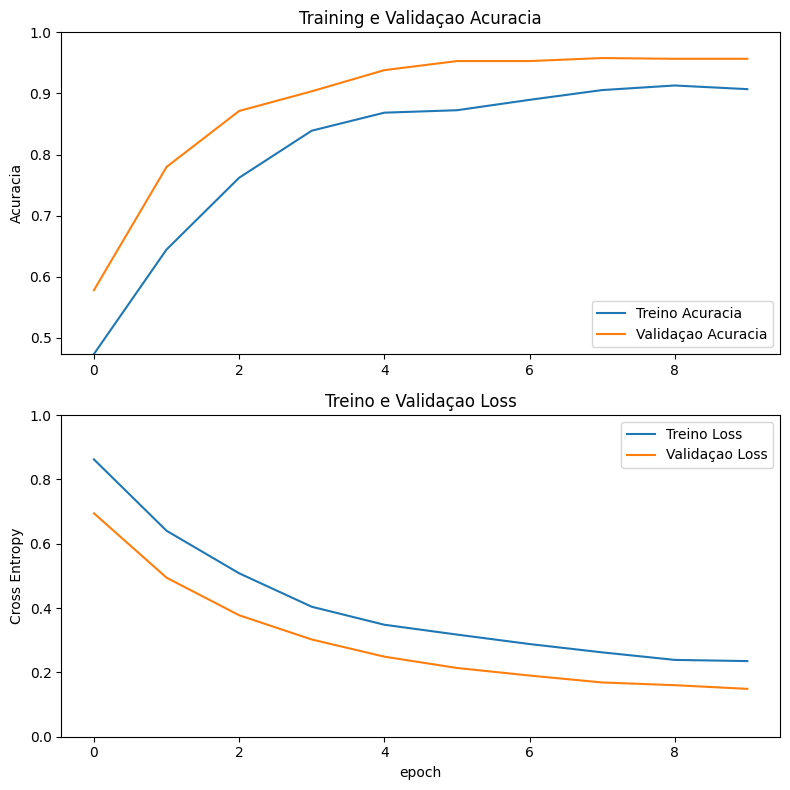

In [ ]:
acc = cnn_treino.history['accuracy']
val_acc = cnn_treino.history['val_accuracy']

loss = cnn_treino.history['loss']
val_loss = cnn_treino.history['val_loss']

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plotando a precisão do treinamento e validação
axs[0].plot(acc, label='Treino Acuracia')
axs[0].plot(val_acc, label='Validaçao Acuracia')
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Acuracia')
axs[0].set_title('Training e Validaçao Acuracia')
axs[0].set_ylim([min(min(acc), min(val_acc)), 1])

# Plotando a perda do treinamento e validação
axs[1].plot(loss, label='Treino Loss')
axs[1].plot(val_loss, label='Validaçao Loss')
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Cross Entropy')
axs[1].set_title('Treino e Validaçao Loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

## Fine-Tuning:
Após o primeiro treinamento, algumas camadas do MobileNetV2 são descongeladas para permitir o ajuste fino (fine-tuning)
agora ajusta os pesos dessas camadas descongeladas para se adaptarem melhor aos dados específicos do conjunto de treinamento

In [ ]:
#Define todas as camadas do modelo base como treináveis
base_model.trainable = True

In [ ]:
# quantidade de camadas existem no modelo base
print("Numero de camadas: ", len(base_model.layers))

#as primeiras 100 camadas do modelo base são definidas como não treináveis.
# essas primeiras camadas não terão seus pesos atualizados.
value_fine_tune = 100
for layer in base_model.layers[:value_fine_tune]:
  layer.trainable = False

Numero de camadas:  154


compila o modelo de rede neural rede_cnn para prepará-lo para o treinamento:

In [ ]:
rede_cnn.compile(loss=BinaryCrossentropy(from_logits=True), #função de perda
              optimizer = RMSprop(learning_rate=0.0001/10), #Define o otimizador a ser utilizado para ajustar os pesos do modelo durante o treinamento
              metrics=[BinaryAccuracy(threshold=0, name='accuracy')])
#métricas a serem utilizadas para avaliar o desempenho do modelo durante o treinamento e validação

Treinamento do modelo com conjunto de treino

In [ ]:
cnn_treino = rede_cnn.fit(train_dataset,
                         epochs=20,
                         initial_epoch=cnn_treino.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 15s 95ms/step - loss: 0.1598 - accuracy: 0.9380 - val_loss: 0.0521 - val_accuracy: 0.9864
Epoch 11/20
63/63 [==============================] - 4s 59ms/step - loss: 0.1260 - accuracy: 0.9460 - val_loss: 0.0438 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1156 - accuracy: 0.9575 - val_loss: 0.0446 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0961 - accuracy: 0.9605 - val_loss: 0.0403 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0887 - accuracy: 0.9625 - val_loss: 0.0413 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 5s 77ms/step - loss: 0.0945 - accuracy: 0.9645 - val_loss: 0.0262 - val_accuracy: 0.9901
Epoch 16/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0719 - accuracy: 0.9675 - val_loss: 0.0531 - val_accuracy: 0.9790
Epoch

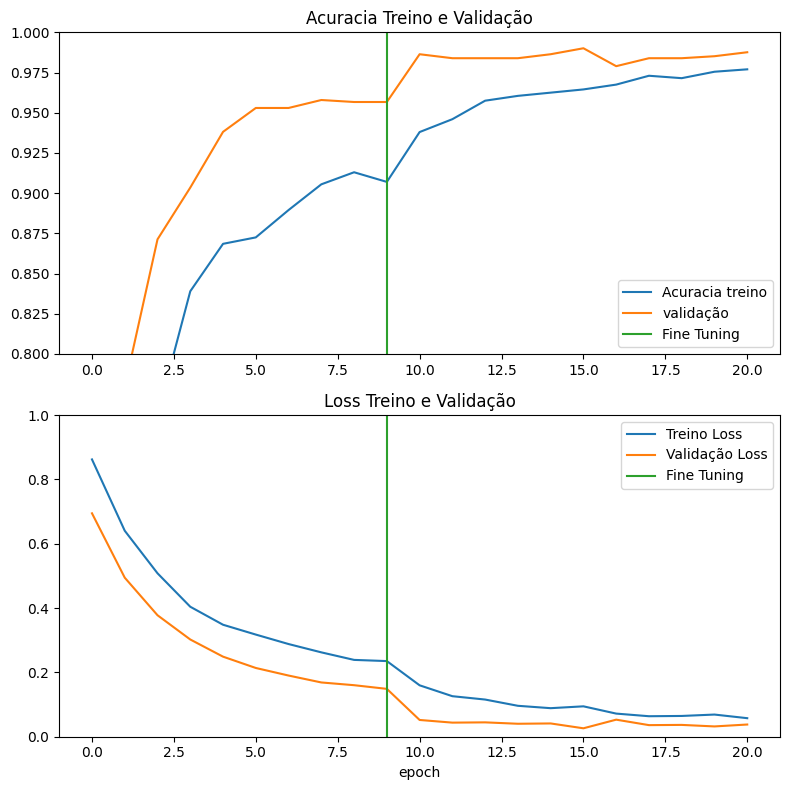

In [ ]:
acc += cnn_treino.history['accuracy']
val_acc += cnn_treino.history['val_accuracy']

loss += cnn_treino.history['loss']
val_loss += cnn_treino.history['val_loss']

epochs = 10
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plotando a precisão do treinamento e validação
axs[0].plot(acc, label='Acuracia treino')
axs[0].plot(val_acc, label='validação')
axs[0].set_ylim([0.8, 1])
axs[0].plot([epochs - 1, epochs - 1], axs[0].get_ylim(), label='Fine Tuning')
axs[0].legend(loc='lower right')
axs[0].set_title('Acuracia Treino e Validação')

# Plotando a perda do treinamento e validação
axs[1].plot(loss, label='Treino Loss')
axs[1].plot(val_loss, label='Validação Loss')
axs[1].set_ylim([0, 1.0])
axs[1].plot([epochs - 1, epochs - 1], axs[1].get_ylim(), label='Fine Tuning')
axs[1].legend(loc='upper right')
axs[1].set_title('Loss Treino e Validação')
axs[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()


In [ ]:
#Avalia o desempenho do modelo com o conjunto de dados de teste
test_loss, test_accuracy = rede_cnn.evaluate(test_dataset)
#evaluate retorna tanto a perda quanto a precisão
print('precisão :', test_accuracy)
print('perda :', test_loss)

6/6 [==============================] - 0s 34ms/step - loss: 0.0550 - accuracy: 0.9844
precisão : 0.984375
perda : 0.05503694340586662


predictions:
 [0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1]
Labels:
 [0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1]


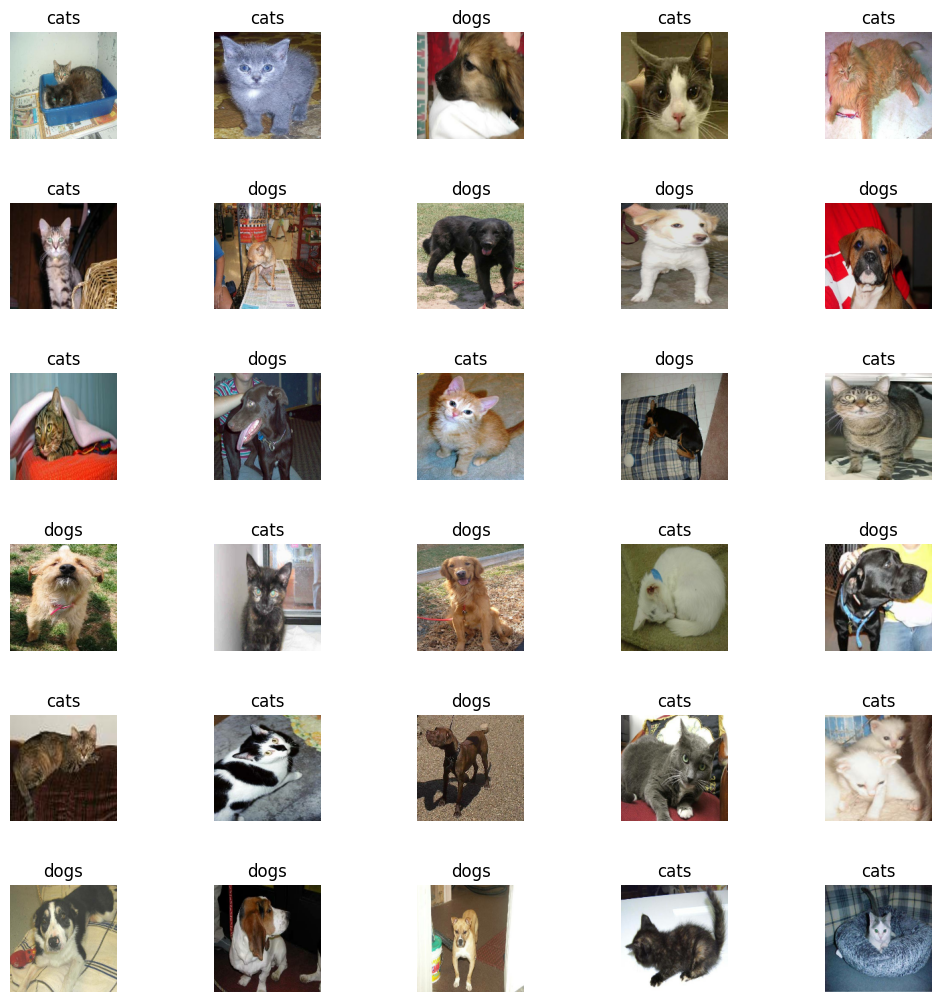

In [ ]:
#Recuperar um lote de imagens do conjunto de testes
test_images, test_label = test_dataset.as_numpy_iterator().next()
cnn_predictions = rede_cnn.predict_on_batch(test_images).flatten()
#realiza a predição
cnn_predictions = tf.nn.sigmoid(cnn_predictions)# aplica sigmoid

# Converte as probabilidades previstas em classes binárias (0 ou 1)
cnn_predictions = tf.where(cnn_predictions < 0.5, 0, 1)

print('predictions:\n', cnn_predictions.numpy())
print('Labels:\n', test_label)

plt.figure(figsize=(12, 12))

# Ajuste de espaçamento e plotagem das imagens
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.6)
for i in range(30):
    ax = plt.subplot(6, 5, i + 1)  # Organização em um grid de 6 linhas e 5 colunas
    plt.imshow(test_images[i].astype("uint8"))
    plt.title(class_names[cnn_predictions[i]])
    plt.axis("off")

plt.show()
